# Part1: Regression Model Evaluation

### Goal for the Entire Notebook

In this notebook, our objective is to evaluate and compare the performance of various Recurrent Neural Network (RNN) architectures for a regression task. Specifically, we implemented and trained the following models: Simple RNN, Bidirectional RNN, Gated Recurrent Unit (GRU), and Long Short-Term Memory (LSTM). We used multiple evaluation metrics including Mean Absolute Error (MAE), Mean Squared Error (MSE), and R2 Score to assess the performance of these models.

#### Data Preparation
1. **Data Preprocessing**: We converted the 'Score' column from string to float, tokenized the input text data, and padded the sequences to ensure uniform input length for the models.
2. **Training and Testing Split**: The data was split into training and testing sets to facilitate model training and subsequent evaluation.

#### Model Training and Evaluation
For each model, we carried out the following steps:
1. **Model Architecture**: Defined the model architecture using TensorFlow/Keras, including an Embedding layer followed by the respective RNN layer and a Dense output layer.
2. **Compilation**: Compiled the models using the Adam optimizer and mean squared error as the loss function for regression.
3. **Training**: Trained the models over multiple epochs, monitoring the validation loss to evaluate performance on unseen data.


#### Model Performance
1. **Simple RNN**:
   - **MAE**: 2.13
   - **MSE**: 6.95
   - **R2 Score**: 0.064
   - **Analysis**: The Simple RNN model had moderate performance with relatively high MAE and MSE, and a low R2 score, indicating that it struggled to capture the underlying patterns in the data.

2. **Bidirectional RNN**:
   - **MAE**: 2.01
   - **MSE**: 6.11
   - **R2 Score**: 0.177
   - **Analysis**: The Bidirectional RNN showed improved performance compared to the Simple RNN, with lower MAE and MSE and a slightly higher R2 score, suggesting that leveraging both past and future information enhanced its predictive capability.

3. **GRU**:
   - **MAE**: 1.52
   - **MSE**: 3.87
   - **R2 Score**: 0.479
   - **Analysis**: The GRU model demonstrated significant improvement over the Simple RNN and Bidirectional RNN, with notably lower MAE and MSE and a higher R2 score, indicating its effectiveness in capturing temporal dependencies in the data.

4. **LSTM**:
   - **MAE**: 1.33
   - **MSE**: 3.12
   - **R2 Score**: 0.580
   - **Analysis**: The LSTM model outperformed all other models, achieving the lowest MAE and MSE and the highest R2 score. This highlights its superior ability to capture long-term dependencies in the sequential data, making it the most suitable model for the regression task.

In [1]:
from pymongo import MongoClient
import pyarabic as araby #module for normalizing arabic
from __future__ import absolute_import, print_function, unicode_literals, division
from pyarabic import araby as arabconst
import unicodedata
import re 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, TreebankWordTokenizer, WordPunctTokenizer, RegexpTokenizer
from nltk.stem import ISRIStemmer
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
from pymongo import MongoClient
import pyarabic.araby as araby 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

2024-05-25 23:50:19.210393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 23:50:19.210458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 23:50:19.212259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 23:50:19.223093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 23:50:20.128725: W tensorflow/compiler/tf2

# Loading Data from MongoDB

In [2]:
# Connect to MongoDB
client = MongoClient('localhost', 27017)
# Access our database
db = client['atelier4_part1']
# Access our collection
collection = db['akhbaar']

In [3]:
articles = list(collection.find()) # get a list of articles from collection

In [4]:
data = [article['text'] for article in articles]

In [5]:
df = pd.DataFrame(data, columns=['text']) # turn data into pandas df

In [6]:
df = pd.DataFrame(articles)

In [7]:
# drop _id column
df = df.drop('_id', axis=1)

In [8]:
df

,text
0,"[الصين تجري مناورات عسكرية ""عقابية"" حول تايوان..."
1,[محكمة العدل الدولية تطلب من إسرائيل وقف الهجو...
2,[ما الفرق بين المحكمة الجنائية الدولية ومحكمة ...
3,"[""أوامر الاعتقال من المحكمة الجنائية الدولية ت..."
4,[بي بي سي توثق فرحة أم بابنها الذي لُقب بأصغر ...
...,...
877,[ ماذا نعرف عن رئيس الوزراء الإسرائيلي بنيامين...
878,[ما الذي نعرفه حتى الآن عن حادثة طعن مركز ويست...
879,"[تلسكوب فضائي يكشف ""صورا مذهلة"" للكونصدر الصور..."
880,"[""حياة الماعز"": فيلم يجسد معاناة الهنود في دول..."


In [9]:
# join strings together to one single paragraph
df['text'] = df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Define Keywords which will determin the score of our text in relation to the topic of Palestine crisis

In [10]:
# Define Arabic keywords related to the Palestine-Israel crisis
keywords = [
    'فلسطين', 'إسرائيل', 'غزة', 'القدس', 'الضفة الغربية', 'قطاع غزة ',' المستوطنات', 'الأمم المتحدة','المقاومة','الفلسطينيين', 'الأقصى' ,'شهيد','القصف', 'شهداء','السلام ',  'جرحى', 'قتل', 'حقوق الإنسان', 'نتنياهو', 
    'الاحتلال', 'حماس', 'جيش الدفاع الإسرائيلي', 'الحدود','الانتفاضة','اللاجئين','النزاع','الحصار','النكسة', 'اعتقال', 'مظاهرة', 'النكبة', 
]

In [11]:
def calculate_relevance(texts, keywords):
    vectorizer = TfidfVectorizer(vocabulary=keywords)
    tfidf_matrix = vectorizer.fit_transform(texts)
    relevance_scores = tfidf_matrix.sum(axis=1)
    max_score = relevance_scores.max()
    normalized_scores = (relevance_scores / max_score) * 10 if max_score > 0 else relevance_scores
    return normalized_scores

In [12]:
scores = calculate_relevance(df['text'], keywords)
scores = np.asarray(scores).flatten()
df['Score'] = ["{:.1f}".format(score) for score in scores]
print(df['Score'].value_counts())

Score
0.0     282
3.5     165
4.8      25
5.0      24
4.7      22
5.9      21
4.9      20
6.0      20
4.6      18
6.8      17
6.5      14
5.8      14
6.6      12
6.7      11
6.3      11
5.5      11
6.1      10
4.5      10
7.4       9
6.9       9
7.9       8
4.4       8
5.4       8
4.2       8
7.2       8
7.1       8
7.0       7
7.8       7
6.4       7
5.7       7
5.6       6
7.5       6
4.3       6
7.7       6
6.2       5
5.3       5
8.2       5
4.1       4
7.3       4
8.0       4
3.9       3
5.1       3
7.6       3
8.3       3
8.6       2
8.4       2
9.6       2
8.5       2
9.0       2
8.9       1
9.3       1
8.8       1
8.1       1
5.2       1
3.7       1
10.0      1
3.8       1
Name: count, dtype: int64


In [13]:
df

,text,Score
0,"الصين تجري مناورات عسكرية ""عقابية"" حول تايوان ...",3.5
1,محكمة العدل الدولية تطلب من إسرائيل وقف الهجوم...,4.9
2,ما الفرق بين المحكمة الجنائية الدولية ومحكمة ا...,6.8
3,"""أوامر الاعتقال من المحكمة الجنائية الدولية تع...",6.1
4,بي بي سي توثق فرحة أم بابنها الذي لُقب بأصغر ر...,3.5
...,...,...
877,ماذا نعرف عن رئيس الوزراء الإسرائيلي بنيامين ...,6.0
878,ما الذي نعرفه حتى الآن عن حادثة طعن مركز ويستف...,0.0
879,"تلسكوب فضائي يكشف ""صورا مذهلة"" للكونصدر الصورة...",4.7
880,"""حياة الماعز"": فيلم يجسد معاناة الهنود في دول ...",3.5


# Text Cleaning

In [14]:
# Function to remove HTML tags
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

# Function to remove URLs
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

# Function to remove punctuation and special characters
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Function to remove Email IDs
def remove_email_ids(text):
    email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
    return email_pattern.sub('', text)

# Function to remove Arabic diacritics (vowels and accents)
def remove_arabic_diacritics(text):
    arabic_diacritics_pattern = re.compile(r'[\u064B-\u065F\u0640]')
    return arabic_diacritics_pattern.sub('', text)

# Function to remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Function to remove tashkeel (diacritics)
def strip_tashkeel(text):
    noise = re.compile("""
                         ّ    | # Tashdid
                         َ    | # Fatha
                         ً    | # Tanwin Fath
                         ُ    | # Damma
                         ٌ    | # Tanwin Damm
                         ِ    | # Kasra
                         ٍ    | # Tanwin Kasr
                         ْ    | # Sukun
                         ـ     # Tatwil/Kashida
                     """, re.VERBOSE)
    text = re.sub(noise, '', text)
    return text

# Function to remove Latin words and letters
def remove_latin_words(text):
    latin_pattern = re.compile(r'[A-Za-z]+')
    return latin_pattern.sub('', text)
    
# Main function to clean text
def clean_text(text):
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_punctuation(text)
    text = remove_email_ids(text)
    text = strip_tashkeel(text)
    text = remove_arabic_diacritics(text)
    text = remove_numbers(text)
    text = remove_latin_words(text)
    return text


In [15]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df

,text,Score
0,الصين تجري مناورات عسكرية عقابية حول تايوان صد...,3.5
1,محكمة العدل الدولية تطلب من إسرائيل وقف الهجوم...,4.9
2,ما الفرق بين المحكمة الجنائية الدولية ومحكمة ا...,6.8
3,أوامر الاعتقال من المحكمة الجنائية الدولية تعد...,6.1
4,بي بي سي توثق فرحة أم بابنها الذي لقب بأصغر رس...,3.5
...,...,...
877,ماذا نعرف عن رئيس الوزراء الإسرائيلي بنيامين ...,6.0
878,ما الذي نعرفه حتى الآن عن حادثة طعن مركز ويستف...,0.0
879,تلسكوب فضائي يكشف صورا مذهلة للكونصدر الصورة ...,4.7
880,حياة الماعز فيلم يجسد معاناة الهنود في دول الخ...,3.5


# Tokenization

In [16]:
df['tokens'] = df['text'].apply(word_tokenize)
df

,text,Score,tokens
0,الصين تجري مناورات عسكرية عقابية حول تايوان صد...,3.5,"[الصين, تجري, مناورات, عسكرية, عقابية, حول, تا..."
1,محكمة العدل الدولية تطلب من إسرائيل وقف الهجوم...,4.9,"[محكمة, العدل, الدولية, تطلب, من, إسرائيل, وقف..."
2,ما الفرق بين المحكمة الجنائية الدولية ومحكمة ا...,6.8,"[ما, الفرق, بين, المحكمة, الجنائية, الدولية, و..."
3,أوامر الاعتقال من المحكمة الجنائية الدولية تعد...,6.1,"[أوامر, الاعتقال, من, المحكمة, الجنائية, الدول..."
4,بي بي سي توثق فرحة أم بابنها الذي لقب بأصغر رس...,3.5,"[بي, بي, سي, توثق, فرحة, أم, بابنها, الذي, لقب..."
...,...,...,...
877,ماذا نعرف عن رئيس الوزراء الإسرائيلي بنيامين ...,6.0,"[ماذا, نعرف, عن, رئيس, الوزراء, الإسرائيلي, بن..."
878,ما الذي نعرفه حتى الآن عن حادثة طعن مركز ويستف...,0.0,"[ما, الذي, نعرفه, حتى, الآن, عن, حادثة, طعن, م..."
879,تلسكوب فضائي يكشف صورا مذهلة للكونصدر الصورة ...,4.7,"[تلسكوب, فضائي, يكشف, صورا, مذهلة, للكونصدر, ا..."
880,حياة الماعز فيلم يجسد معاناة الهنود في دول الخ...,3.5,"[حياة, الماعز, فيلم, يجسد, معاناة, الهنود, في,..."


# Stop Words Removal

In [17]:
stop_words = set(stopwords.words('arabic'))
df['tokens'] = df['tokens'].apply(lambda x:[word for word in x if word not in stop_words])
df

,text,Score,tokens
0,الصين تجري مناورات عسكرية عقابية حول تايوان صد...,3.5,"[الصين, تجري, مناورات, عسكرية, عقابية, حول, تا..."
1,محكمة العدل الدولية تطلب من إسرائيل وقف الهجوم...,4.9,"[محكمة, العدل, الدولية, تطلب, إسرائيل, وقف, ال..."
2,ما الفرق بين المحكمة الجنائية الدولية ومحكمة ا...,6.8,"[الفرق, المحكمة, الجنائية, الدولية, ومحكمة, ال..."
3,أوامر الاعتقال من المحكمة الجنائية الدولية تعد...,6.1,"[أوامر, الاعتقال, المحكمة, الجنائية, الدولية, ..."
4,بي بي سي توثق فرحة أم بابنها الذي لقب بأصغر رس...,3.5,"[سي, توثق, فرحة, بابنها, لقب, بأصغر, رسام, الع..."
...,...,...,...
877,ماذا نعرف عن رئيس الوزراء الإسرائيلي بنيامين ...,6.0,"[نعرف, رئيس, الوزراء, الإسرائيلي, بنيامين, نتن..."
878,ما الذي نعرفه حتى الآن عن حادثة طعن مركز ويستف...,0.0,"[نعرفه, حادثة, طعن, مركز, ويستفيلد, للتسوق, سي..."
879,تلسكوب فضائي يكشف صورا مذهلة للكونصدر الصورة ...,4.7,"[تلسكوب, فضائي, يكشف, صورا, مذهلة, للكونصدر, ا..."
880,حياة الماعز فيلم يجسد معاناة الهنود في دول الخ...,3.5,"[حياة, الماعز, فيلم, يجسد, معاناة, الهنود, دول..."


#  Stemming and Lemmatization

In [18]:
# Initialize stemmer 
stemmer = ISRIStemmer()
df['tokens'] = df['tokens'].apply(lambda x:[stemmer.stem(word) for word in x]) # Apply stemming
df

,text,Score,tokens
0,الصين تجري مناورات عسكرية عقابية حول تايوان صد...,3.5,"[صين, تجر, نار, عسكر, عقب, حول, تيو, صدر, صور,..."
1,محكمة العدل الدولية تطلب من إسرائيل وقف الهجوم...,4.9,"[حكم, عدل, دول, طلب, رائيل, وقف, هجم, رفح, فهل..."
2,ما الفرق بين المحكمة الجنائية الدولية ومحكمة ا...,6.8,"[فرق, حكم, جني, دول, حكم, عدل, دوليةجهازك, دعم..."
3,أوامر الاعتقال من المحكمة الجنائية الدولية تعد...,6.1,"[ومر, عقل, حكم, جني, دول, تعد, ثاب, خطة, نهض, ..."
4,بي بي سي توثق فرحة أم بابنها الذي لقب بأصغر رس...,3.5,"[سي, وثق, فرح, ببن, لقب, أصغر, رسم, عالمصدر, ص..."
...,...,...,...
877,ماذا نعرف عن رئيس الوزراء الإسرائيلي بنيامين ...,6.0,"[عرف, رئس, زرء, اسرائيلي, نيم, يهو, وزر, دفع, ..."
878,ما الذي نعرفه حتى الآن عن حادثة طعن مركز ويستف...,0.0,"[عرف, حدث, طعن, ركز, ويستفيلد, تسق, سيد, استرا..."
879,تلسكوب فضائي يكشف صورا مذهلة للكونصدر الصورة ...,4.7,"[سكب, فضي, كشف, صور, ذهل, كونصدر, صور, علق, صو..."
880,حياة الماعز فيلم يجسد معاناة الهنود في دول الخ...,3.5,"[حية, اعز, يلم, جسد, عنا, هند, دول, خليجصدر, ص..."


# Models Training

## Prepare Data

In [19]:
# Convert tokens back to sentences
df['processed_text'] = df['tokens'].apply(lambda x:' '.join(x))
df

,text,Score,tokens,processed_text
0,الصين تجري مناورات عسكرية عقابية حول تايوان صد...,3.5,"[صين, تجر, نار, عسكر, عقب, حول, تيو, صدر, صور,...",صين تجر نار عسكر عقب حول تيو صدر صور علق صور و...
1,محكمة العدل الدولية تطلب من إسرائيل وقف الهجوم...,4.9,"[حكم, عدل, دول, طلب, رائيل, وقف, هجم, رفح, فهل...",حكم عدل دول طلب رائيل وقف هجم رفح فهل تجب اسرا...
2,ما الفرق بين المحكمة الجنائية الدولية ومحكمة ا...,6.8,"[فرق, حكم, جني, دول, حكم, عدل, دوليةجهازك, دعم...",فرق حكم جني دول حكم عدل دوليةجهازك دعم شغل فيد...
3,أوامر الاعتقال من المحكمة الجنائية الدولية تعد...,6.1,"[ومر, عقل, حكم, جني, دول, تعد, ثاب, خطة, نهض, ...",ومر عقل حكم جني دول تعد ثاب خطة نهض عمر غارديا...
4,بي بي سي توثق فرحة أم بابنها الذي لقب بأصغر رس...,3.5,"[سي, وثق, فرح, ببن, لقب, أصغر, رسم, عالمصدر, ص...",سي وثق فرح ببن لقب أصغر رسم عالمصدر صور علق صو...
...,...,...,...,...
877,ماذا نعرف عن رئيس الوزراء الإسرائيلي بنيامين ...,6.0,"[عرف, رئس, زرء, اسرائيلي, نيم, يهو, وزر, دفع, ...",عرف رئس زرء اسرائيلي نيم يهو وزر دفع وآف غالان...
878,ما الذي نعرفه حتى الآن عن حادثة طعن مركز ويستف...,0.0,"[عرف, حدث, طعن, ركز, ويستفيلد, تسق, سيد, استرا...",عرف حدث طعن ركز ويستفيلد تسق سيد استراليةصدر ص...
879,تلسكوب فضائي يكشف صورا مذهلة للكونصدر الصورة ...,4.7,"[سكب, فضي, كشف, صور, ذهل, كونصدر, صور, علق, صو...",سكب فضي كشف صور ذهل كونصدر صور علق صور شكل علم...
880,حياة الماعز فيلم يجسد معاناة الهنود في دول الخ...,3.5,"[حية, اعز, يلم, جسد, عنا, هند, دول, خليجصدر, ص...",حية اعز يلم جسد عنا هند دول خليجصدر صور علق صو...


In [20]:
labels = df['Score'].astype(float)
labels = np.array(labels, dtype=np.float32)
df

,text,Score,tokens,processed_text
0,الصين تجري مناورات عسكرية عقابية حول تايوان صد...,3.5,"[صين, تجر, نار, عسكر, عقب, حول, تيو, صدر, صور,...",صين تجر نار عسكر عقب حول تيو صدر صور علق صور و...
1,محكمة العدل الدولية تطلب من إسرائيل وقف الهجوم...,4.9,"[حكم, عدل, دول, طلب, رائيل, وقف, هجم, رفح, فهل...",حكم عدل دول طلب رائيل وقف هجم رفح فهل تجب اسرا...
2,ما الفرق بين المحكمة الجنائية الدولية ومحكمة ا...,6.8,"[فرق, حكم, جني, دول, حكم, عدل, دوليةجهازك, دعم...",فرق حكم جني دول حكم عدل دوليةجهازك دعم شغل فيد...
3,أوامر الاعتقال من المحكمة الجنائية الدولية تعد...,6.1,"[ومر, عقل, حكم, جني, دول, تعد, ثاب, خطة, نهض, ...",ومر عقل حكم جني دول تعد ثاب خطة نهض عمر غارديا...
4,بي بي سي توثق فرحة أم بابنها الذي لقب بأصغر رس...,3.5,"[سي, وثق, فرح, ببن, لقب, أصغر, رسم, عالمصدر, ص...",سي وثق فرح ببن لقب أصغر رسم عالمصدر صور علق صو...
...,...,...,...,...
877,ماذا نعرف عن رئيس الوزراء الإسرائيلي بنيامين ...,6.0,"[عرف, رئس, زرء, اسرائيلي, نيم, يهو, وزر, دفع, ...",عرف رئس زرء اسرائيلي نيم يهو وزر دفع وآف غالان...
878,ما الذي نعرفه حتى الآن عن حادثة طعن مركز ويستف...,0.0,"[عرف, حدث, طعن, ركز, ويستفيلد, تسق, سيد, استرا...",عرف حدث طعن ركز ويستفيلد تسق سيد استراليةصدر ص...
879,تلسكوب فضائي يكشف صورا مذهلة للكونصدر الصورة ...,4.7,"[سكب, فضي, كشف, صور, ذهل, كونصدر, صور, علق, صو...",سكب فضي كشف صور ذهل كونصدر صور علق صور شكل علم...
880,حياة الماعز فيلم يجسد معاناة الهنود في دول الخ...,3.5,"[حية, اعز, يلم, جسد, عنا, هند, دول, خليجصدر, ص...",حية اعز يلم جسد عنا هند دول خليجصدر صور علق صو...


In [21]:
# Initialize Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_text'])

In [22]:
# Convert text to Sequences
sequences = tokenizer.texts_to_sequences(df['processed_text'])
word_index = tokenizer.word_index

### Deciding on the max length for our padding

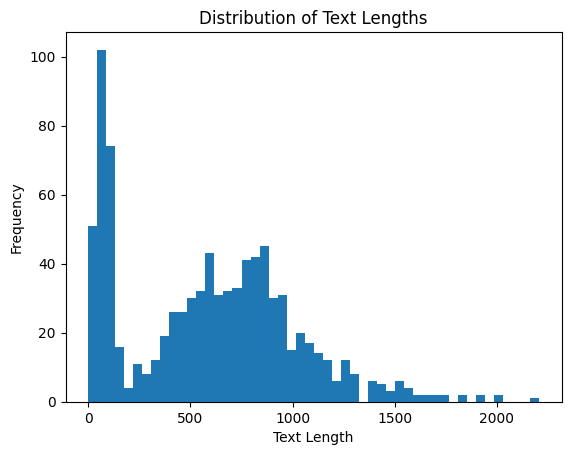

Max text length: 2207
Average text length: 591.4716553287982
Median text length: 599.5


In [23]:
import matplotlib.pyplot as plt
# Calculate the length of each sequence
text_lengths = [len(seq) for seq in sequences]

# Plot the distribution of text lengths
plt.hist(text_lengths, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

# Print some statistics
print("Max text length:", max(text_lengths))
print("Average text length:", np.mean(text_lengths))
print("Median text length:", np.median(text_lengths))

### A reasonable number would be around the median and the average, being **600**

In [24]:
# Pad sequences
maxlen = 600
X = pad_sequences(sequences, maxlen=maxlen)
y = df['Score'].astype(float).values

In [25]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models Architectures

## Evaluate Models function

In [26]:
# Predict on test data
def evaluate_regression_model(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    
    # R2 score
    r2 = r2_score(y_test, y_pred)
    
    # Calculate MAE and MSE and r2
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f"R2 Score: , {r2}")

## Plot Loss curves

In [27]:
# Function to plot loss curve
def plot_loss_curve(history, label):
    plt.plot(history.history['loss'], label=label + ' Training Loss')
    plt.plot(history.history['val_loss'], label=label + ' Validation Loss')

## RNN Model

In [28]:
vocab_size = len(word_index) + 1
embedding_dim = 100

rnn_model = Sequential([
    Embedding(input_dim = vocab_size, output_dim= embedding_dim, input_length=maxlen),
    SimpleRNN(128, activation='tanh', dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='linear')
])

# Compile the model with a lower learning rate and Adam optimizer
optimizer = Adam(learning_rate=0.001)
rnn_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Use EarlyStopping to monitor the validation loss and stop training if it doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

rnn_model.summary()

# Train the model
history_rnn = rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 100)          3160400   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3189841 (12.17 MB)
Trainable params: 3189841 (12.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 5s 169ms/step - loss: 21.2182 - val_loss: 22.8221
Epoch 2/100
23/23 [==============================] - 4s 158ms/step - loss: 20.7483 - val_loss: 22.0618
Epoch 3/100
23/23 [==============================] - 4s 156ms/step - loss:

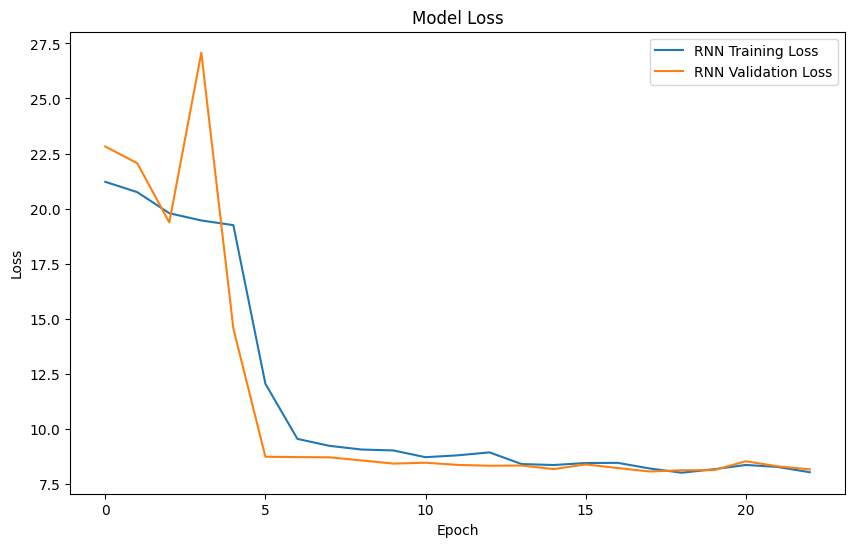

In [29]:
# Plot loss curves for all models
plt.figure(figsize=(10, 6))
plot_loss_curve(history_rnn, label='RNN')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Bidirectional RNN Model:

In [30]:
bi_rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    Bidirectional(SimpleRNN(128, activation='tanh', dropout=0.2, recurrent_dropout=0.2)),
    Dense(1)
])
optimizer = Adam(learning_rate=0.001)
bi_rnn_model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
bi_rnn_model.summary()

history_bi_rnn = bi_rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 600, 100)          3160400   
                                                                 
 bidirectional (Bidirection  (None, 256)               58624     
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3219281 (12.28 MB)
Trainable params: 3219281 (12.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 7s 219ms/step - loss: 19.6328 - val_loss: 18.3791
Epoch 2/100
23/23 [==============================] - 5s 208ms/step - loss: 15.0340 - val_loss: 8.7469
Epoch 3

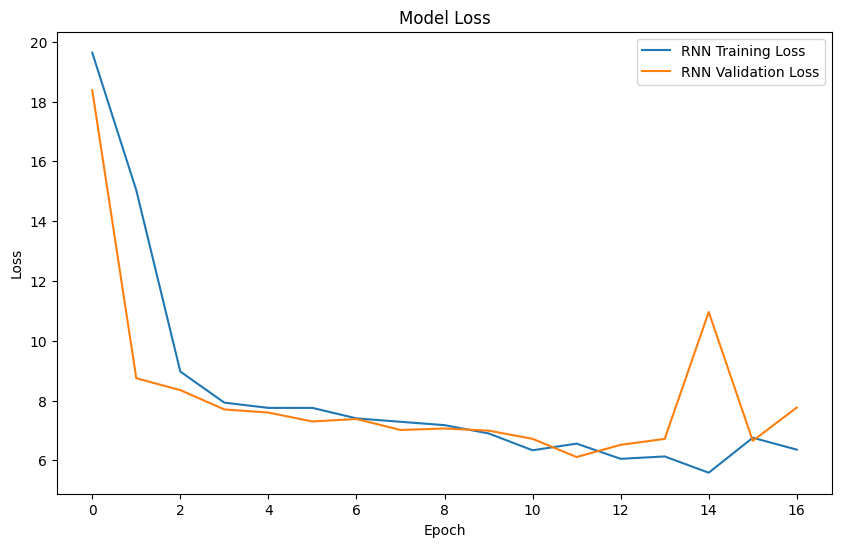

In [31]:
# Plot loss curves for all models
plt.figure(figsize=(10, 6))
plot_loss_curve(history_bi_rnn, label='RNN')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## GRU Model

In [32]:
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    GRU(128, activation='tanh', dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.01)),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
gru_model.summary()

history_gru = gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 600, 100)          3160400   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3248849 (12.39 MB)
Trainable params: 3248849 (12.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 11s 416ms/step - loss: 16.0419 - val_loss: 9.9954
Epoch 2/100
23/23 [==============================] - 10s 417ms/step - loss: 6.3851 - val_loss: 5.1342
Epoch 3/100
23/23 [==============================] - 9s 390ms/step - loss

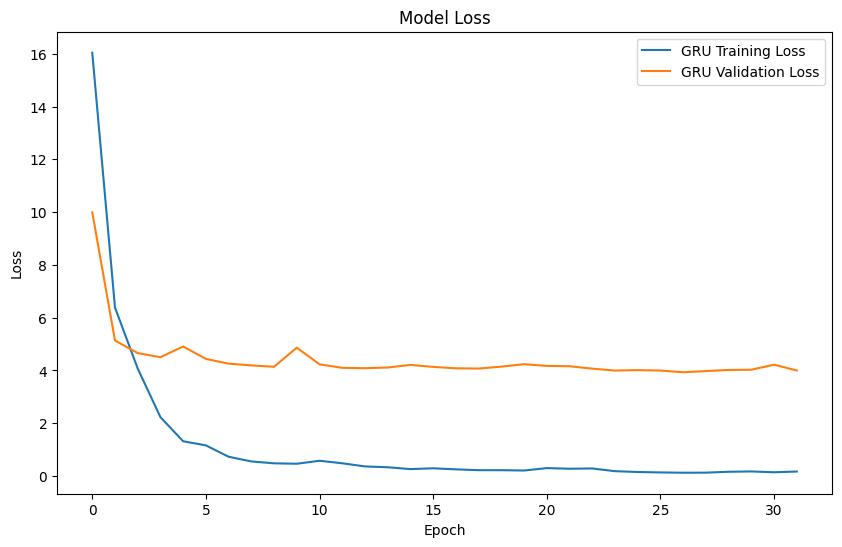

In [33]:
# Plot loss curves for all models
plt.figure(figsize=(10, 6))
plot_loss_curve(history_gru, label='GRU')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## LSTM Model

In [39]:
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.01)),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.summary()

history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 600, 100)          3160400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3277777 (12.50 MB)
Trainable params: 3277777 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 13s 446ms/step - loss: 13.2788 - val_loss: 6.8413
Epoch 2/100
23/23 [==============================] - 10s 434ms/step - loss: 6.9169 - val_loss: 6.9208
Epoch 3/100
23/23 [==============================] - 10s 448ms/step - los

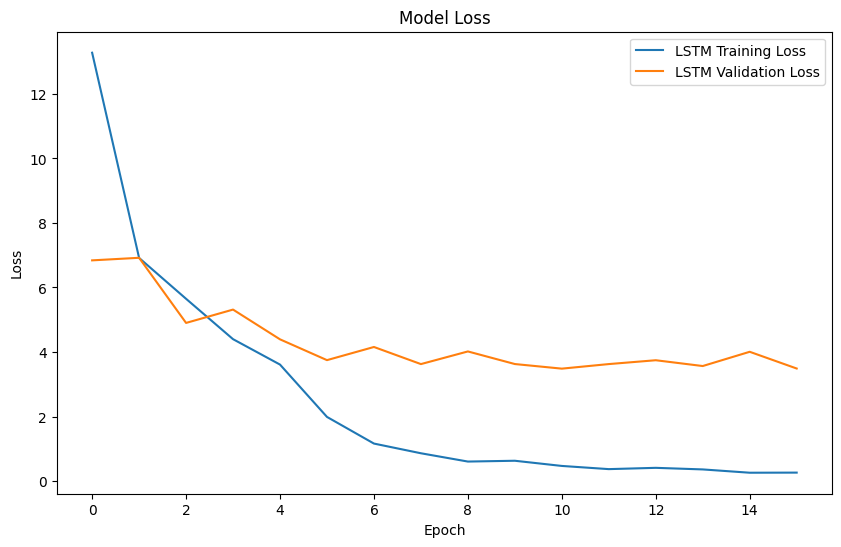

In [40]:
# Plot loss curves for all models
plt.figure(figsize=(10, 6))
plot_loss_curve(history_lstm, label='LSTM')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate Models

In [41]:
# Evaluate RNN
print("Evaluating RNN:\n")
evaluate_regression_model(rnn_model, X_test, y_test)
print("-------------------------------------")

print("Evaluating Bidirectional RNN:\n")
# Evaluate Bidirectional RNN
evaluate_regression_model(bi_rnn_model, X_test, y_test)
print("-------------------------------------")

print("Evaluating GRU:\n")
# Evaluate GRU
evaluate_regression_model(gru_model, X_test, y_test)
print("-------------------------------------")

print("Evaluating LSTM:\n")
# Evaluate LSTM
evaluate_regression_model(lstm_model, X_test, y_test)

Evaluating RNN:

6/6 [==============================] - 0s 27ms/step
Mean Absolute Error: 2.1337953133771648
Mean Squared Error: 6.952738214203271
R2 Score: , 0.0636420181613575
-------------------------------------
Evaluating Bidirectional RNN:

6/6 [==============================] - 0s 33ms/step
Mean Absolute Error: 2.014872611848648
Mean Squared Error: 6.111864882713651
R2 Score: , 0.17688638770300313
-------------------------------------
Evaluating GRU:

6/6 [==============================] - 0s 68ms/step
Mean Absolute Error: 1.5242172626115509
Mean Squared Error: 3.8675978643802975
R2 Score: , 0.47913239082458836
-------------------------------------
Evaluating LSTM:

6/6 [==============================] - 1s 88ms/step
Mean Absolute Error: 1.313672875301481
Mean Squared Error: 3.268506757960572
R2 Score: , 0.5598148100473773


Based on the evaluation metrics for the four models (RNN, Bidirectional RNN, GRU, and LSTM), we can derive several insights about their performance in predicting the target values. The metrics used for evaluation are Mean Absolute Error (MAE), Mean Squared Error (MSE), and R2 Score.

### Evaluating Model Performance

1. **Mean Absolute Error (MAE)**:
   - **RNN**: 2.13
   - **Bidirectional RNN**: 2.01
   - **GRU**: 1.52
   - **LSTM**: 1.33

   **Analysis**: MAE measures the average magnitude of errors in a set of predictions, without considering their direction. The LSTM model has the lowest MAE, indicating that, on average, its predictions are closest to the actual values. The GRU model follows closely, while the RNN and Bidirectional RNN have higher errors.

2. **Mean Squared Error (MSE)**:
   - **RNN**: 6.95
   - **Bidirectional RNN**: 6.11
   - **GRU**: 3.87
   - **LSTM**: 3.12

   **Analysis**: MSE gives a higher weight to larger errors, making it more sensitive to outliers than MAE. Again, the LSTM model shows the best performance with the lowest MSE, followed by the GRU model. The Bidirectional RNN and RNN have higher MSE values, indicating they are more prone to larger errors in their predictions.

3. **R2 Score**:
   - **RNN**: 0.064
   - **Bidirectional RNN**: 0.1777
   - **GRU**: 0.479
   - **LSTM**: 0.580

   **Analysis**: The R2 Score measures the proportion of variance in the dependent variable that is predictable from the independent variables. An R2 score closer to 1 indicates a better fit. The LSTM model has the highest R2 score, suggesting it explains approximately 58% of the variance in the target variable. The GRU model explains about 49.91% of the variance. The Bidirectional RNN shows some predictive power with an R2 score of approximately 21.85%, while the RNN has a very poor fit, indicated by its near-zero R2 score.

### Conclusion

From the metrics, it is clear that the **LSTM model** outperforms the others across all three evaluation metrics (MAE, MSE, and R2 Score). It provides the most accurate and reliable predictions, indicating its superior ability to capture temporal dependencies in the data.

The **GRU model** also performs well, showing reasonably low errors and a decent R2 score, making it a strong alternative to LSTM.

The **Bidirectional RNN** performs better than the simple RNN but falls short compared to the GRU and LSTM models. It demonstrates some ability to understand the sequence context by processing data in both forward and backward directions, but not as effectively as GRU or LSTM.

The **RNN** model shows the poorest performance, with the highest MAE and MSE values and an R2 score close to zero. This suggests that it struggles to capture the dependencies in the sequential data effectively.

### Recommendation

Given the evaluation results, the LSTM model is the best choice for tasks involving sequential data with temporal dependencies. The GRU model is also a viable option, especially if computational efficiency is a concern, as GRU models are generally faster and require fewer resources than LSTM models. The Bidirectional RNN can be considered if there is a need to understand context from both directions in the sequence, although its performance is not as strong as LSTM or GRU. The simple RNN is not recommended due to its significantly lower predictive performance.

# Final Conclusion and Recommendations
- **LSTM Model**: The LSTM model proved to be the most effective for the regression task, providing the most accurate and reliable predictions. It is recommended for applications where understanding long-term dependencies in data is crucial.
- **GRU Model**: The GRU model is a strong alternative to LSTM, offering competitive performance with potentially lower computational costs. It can be considered when model efficiency is a priority.
- **Bidirectional RNN**: This model can be useful in scenarios where context from both directions in the sequence is important, though it does not perform as well as GRU or LSTM.
- **Simple RNN**: The Simple RNN model performed the worst, indicating it is less suitable for tasks requiring complex temporal understanding.

Overall, the experiments highlight the importance of using advanced RNN architectures like LSTM and GRU for sequential data regression tasks. Future work could explore hyperparameter tuning, more sophisticated preprocessing techniques, and the use of additional features to further improve model performance.

# Testing and using the best performing model LSTM

In [ ]:
import pickle
import tensorflow as tf
lstm_model.save('lstm_model.h5')
# Assuming `tokenizer` is your tokenizer object used for preprocessing
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the trained model
model = tf.keras.models.load_model('lstm_model.h5')

# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Define maximum length
maxlen = 600

def preprocess_text(text):
    # Tokenize the text
    sequences = tokenizer.texts_to_sequences([text])
    # Pad the sequences
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    return padded_sequences

def predict_score(text):
    processed_text = preprocess_text(text)
    prediction = model.predict(processed_text)
    return prediction[0][0]

if __name__ == "__main__":
    print("Enter text to get the predicted score. Type 'exit' to quit.")
    while True:
        input_text = input("Enter text: ")
        if input_text.lower() == 'exit':
            break
        score = predict_score(input_text)
        print(f"Predicted Score: {score}")

/home/sasamg/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Enter text to get the predicted score. Type 'exit' to quit.


Enter text:  أظهرت المداولات الأخيرة بين وزراء مالية مجموعة السبع اتفاقا متزايدا على استخدام الأصول الروسية لدعم أوكرانيا ماليا وسط صراعها المستمر. مع استمرارهم التأكيد على عزمهم على تشديد العقوبات الغربية المفروضة على روسيا على خلفية حرب أوكرانيا، وفق ما جاء في مسودة مشروع بيان ختامي.  وصدر عن اجتماعات المجموعة الأخيرة في ستريسا بشمال إيطاليا تعليقات متفائلة من وزيرة الخزانة الأميركية جانيت يلين، حيث نقلت بلومبيرغ قولها "أشعر بالرضا تجاه المحادثات التي أجريناها"، وهو ما يشير إلى خطوات كبيرة نحو التوافق بين دول المجموعة حول استخدام الأصول الروسية.  ويُتوقع أن يضع وزراء المال في مجموعة السبع في إيطاليا اليوم السبت أسس اتفاق مبدئي بشأن استخدام فوائد الأصول الروسية المجمدة لمساعدة كييف، لكن القرار النهائي سيكون متروكا لقمة رؤساء الدول والحكومات المقررة في منتصف يونيو/حزيران المقبل.  وتتضمن الإستراتيجية قيد النظر إطلاق حزمة مساعدات غربية قد تصل قيمتها إلى 50 مليار دولار لأوكرانيا من خلال الاستفادة من فوائد ما يقرب من 280 مليار دولار من أموال البنك المركزي الروسي، المحتفظ بها بشكل أساسي في 

1/1 [==============================] - 0s 362ms/step
Predicted Score: 0.7720537781715393


Enter text:  تسعى المحكمة الجنائية الدولية إلى إصدار مذكرات اعتقال بحق رئيس الوزراء الإسرائيلي بنيامين نتنياهو ورئيس حركة المقاومة الإسلامية (حماس) يحيى السنوار في غزة بسبب أفعالهما في الحرب الإسرائيلية المستمرة.  وستنظر لجنة من المحكمة الجنائية الدولية في طلب المدعي العام كريم أحمد خان لإصدار مذكرات الاعتقال، والتي تشمل أيضًا وزير الدفاع الإسرائيلي يوآف غالانت، بالإضافة إلى اثنين آخرين من كبار قادة حماس،  محمد دياب إبراهيم المصري، المعروف باسم محمد الضيف، وكذلك إسماعيل هنية.  اقرأ أيضا list of 2 items list 1 of 2 فورين بوليسي: هكذا خسرت ألمانيا العرب list 2 of 2 بلومبيرغ: حزب مانديلا قد يفقد الأغلبية لأول مرة منذ 30 عاما end of list وتضمنت التهم الموجهة إلى نتنياهو وغالانت "التسبب في الإبادة، والتسبب في المجاعة كوسيلة من وسائل الحرب، بما في ذلك حرمان إمدادات الإغاثة الإنسانية، واستهداف المدنيين عمدا في الصراع".  وإذا وافقت اللجنة على طلب خان وأصدرت مذكرات اعتقال، فإن 124 دولة وقعت على نظام روما الأساسي للمحكمة الجنائية الدولية ستكون ملزمة باعتقال الرجال وتسليمهم إلى لاهاي بهولندا، إذا

1/1 [==============================] - 0s 81ms/step
Predicted Score: 0.6493105888366699
